In [1]:
# Install required packages
!pip install kagglehub tensorflow scikit-learn matplotlib seaborn -q

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Import all required libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [4]:
import os

path = kagglehub.dataset_download("sloozecareers/slooze-challenge")
print(f"Dataset downloaded to: {path}\n")

data_dir = path
subdirs = [f.path for f in os.scandir(path) if f.is_dir()]
if subdirs:
    data_dir = subdirs[0]
print(f"Data files are expected in: {data_dir}\n")


# Load all datasets
sales_df = pd.read_csv(f"{data_dir}/SalesFINAL12312016.csv")
purchases_df = pd.read_csv(f"{data_dir}/PurchasesFINAL12312016.csv")
invoice_purchases_df = pd.read_csv(f"{data_dir}/InvoicePurchases12312016.csv")
beg_inventory_df = pd.read_csv(f"{data_dir}/BegInvFINAL12312016.csv")
end_inventory_df = pd.read_csv(f"{data_dir}/EndInvFINAL12312016.csv")
purchase_prices_df = pd.read_csv(f"{data_dir}/2017PurchasePricesDec.csv")

print(f"Sales: {len(sales_df):,} records")
print(f"Purchases: {len(purchases_df):,} records")
print(f"Invoice Purchases: {len(invoice_purchases_df):,} records")
print(f"Beginning Inventory: {len(beg_inventory_df):,} records")
print(f"Ending Inventory: {len(end_inventory_df):,} records")
print(f"Purchase Prices: {len(purchase_prices_df):,} records")

print("\SALES DATA - First 3 rows:")
sales_df.head(3)

Dataset downloaded to: /root/.cache/kagglehub/datasets/sloozecareers/slooze-challenge/versions/1

Data files are expected in: /root/.cache/kagglehub/datasets/sloozecareers/slooze-challenge/versions/1/slooze_challenge

Sales: 1,048,575 records
Purchases: 2,372,474 records
Invoice Purchases: 5,543 records
Beginning Inventory: 206,529 records
Ending Inventory: 224,489 records
Purchase Prices: 12,261 records
\SALES DATA - First 3 rows:


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY


In [5]:
# Explore sales data structure
print("=== SALES DATA INFO ===")
print(f"Shape: {sales_df.shape}")
print(f"\nColumns: {sales_df.columns.tolist()}")
print(f"\nData types:\n{sales_df.dtypes}")
print(f"\nMissing values:\n{sales_df.isnull().sum()}")

# Display first few rows
print("\Sample Data:")
print(sales_df.head())

# Basic statistics
print("\n=== NUMERIC COLUMNS SUMMARY ===")
print(sales_df.describe())

# Identify key columns
date_columns = [col for col in sales_df.columns if 'date' in col.lower()]
product_columns = [col for col in sales_df.columns if any(x in col.lower() for x in ['brand', 'item', 'product', 'description'])]
quantity_columns = [col for col in sales_df.columns if any(x in col.lower() for x in ['quantity', 'qty', 'bottles'])]
price_columns = [col for col in sales_df.columns if any(x in col.lower() for x in ['price', 'dollars', 'sales'])]

print(f"\n IDENTIFIED COLUMNS:")
print(f"Date columns: {date_columns}")
print(f"Product columns: {product_columns}")
print(f"Quantity columns: {quantity_columns}")
print(f"Price/Sales columns: {price_columns}")

# Convert date if exists
if date_columns:
    date_col = date_columns[0]
    sales_df[date_col] = pd.to_datetime(sales_df[date_col])
    print(f"\Date range: {sales_df[date_col].min()} to {sales_df[date_col].max()}")
    print(f"Total days: {(sales_df[date_col].max() - sales_df[date_col].min()).days} days")

=== SALES DATA INFO ===
Shape: (1048575, 14)

Columns: ['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity', 'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification', 'ExciseTax', 'VendorNo', 'VendorName']

Data types:
InventoryId        object
Store               int64
Brand               int64
Description        object
Size               object
SalesQuantity       int64
SalesDollars      float64
SalesPrice        float64
SalesDate          object
Volume              int64
Classification      int64
ExciseTax         float64
VendorNo            int64
VendorName         object
dtype: object

Missing values:
InventoryId       0
Store             0
Brand             0
Description       0
Size              0
SalesQuantity     0
SalesDollars      0
SalesPrice        0
SalesDate         0
Volume            0
Classification    0
ExciseTax         0
VendorNo          0
VendorName        0
dtype: int64
\Sample Data:
           InventoryId  Store  Brand          

Using columns: Date=SalesDate, Product=Brand, Quantity=SalesQuantity, Price=SalesDollars


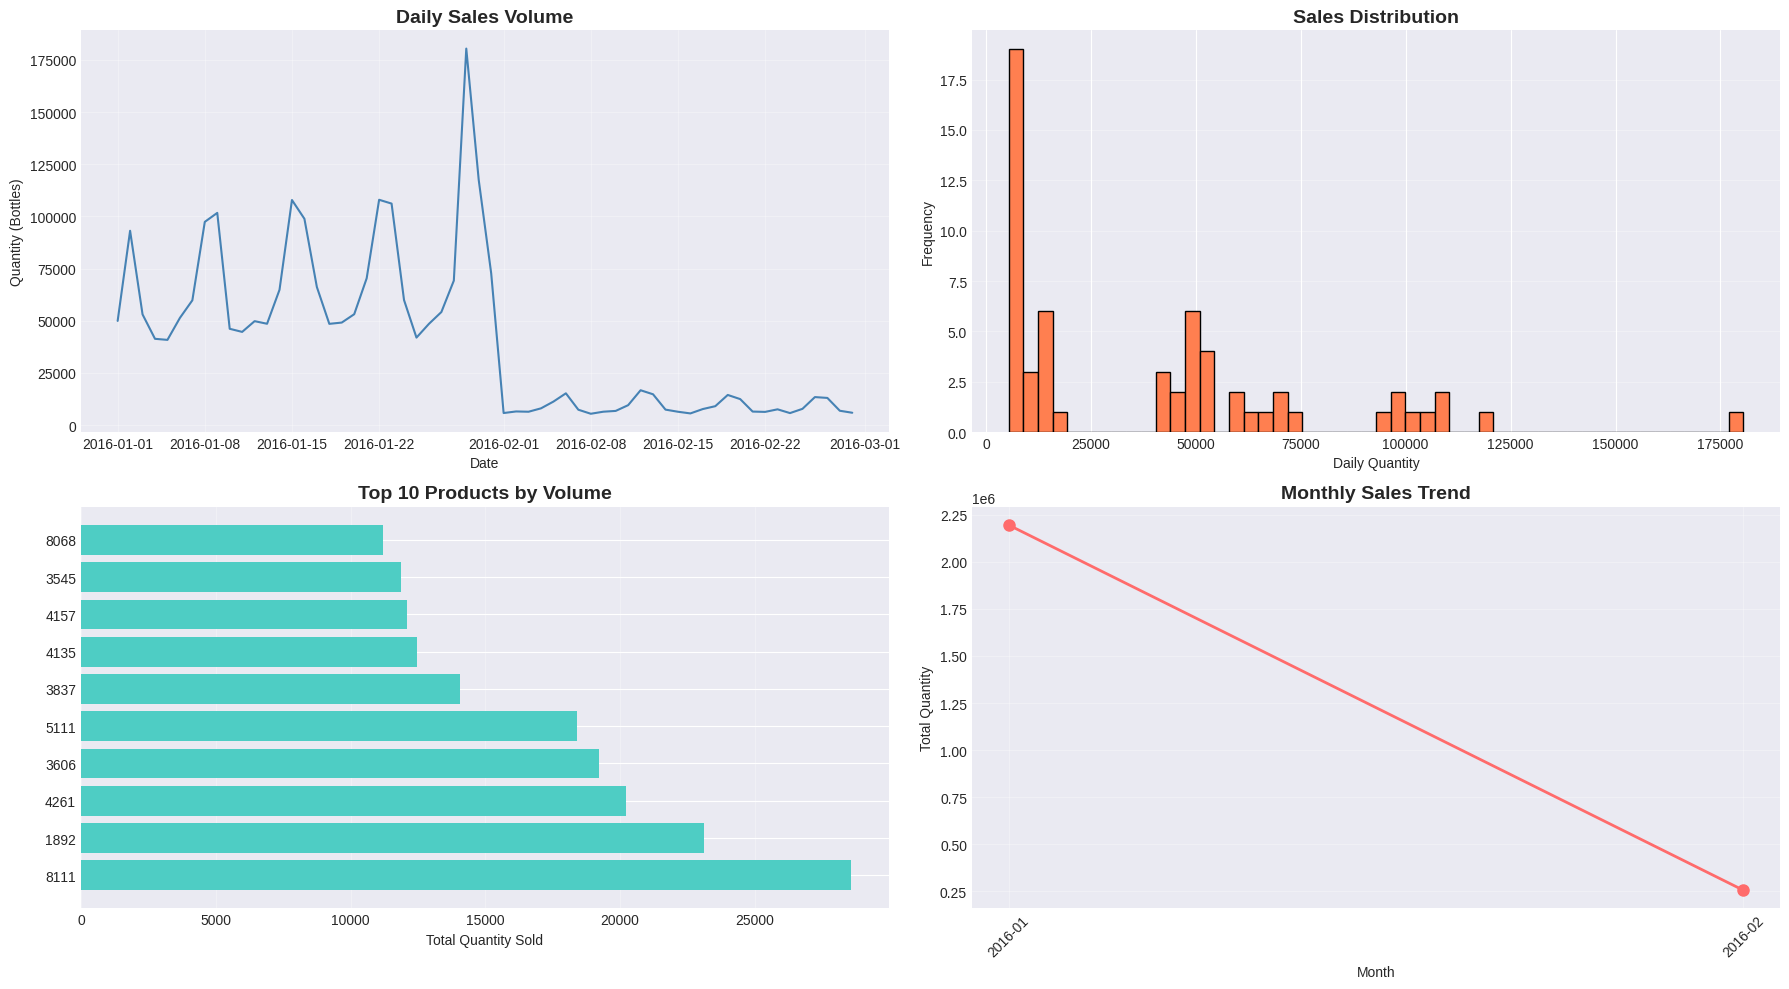


SALES SUMMARY:
   Total Products: 7,658
   Total Quantity Sold: 2,451,169
   Average Daily Sales: 40,853
   Max Daily Sales: 180,426
   Min Daily Sales: 5,425


In [6]:

date_col = 'InventoryDate' if 'InventoryDate' in sales_df.columns else date_columns[0]
product_col = 'Brand' if 'Brand' in sales_df.columns else product_columns[0]
quantity_col = 'SalesQuantity' if 'SalesQuantity' in sales_df.columns else quantity_columns[0]
price_col = 'SalesDollars' if 'SalesDollars' in sales_df.columns else price_columns[0]

print(f"Using columns: Date={date_col}, Product={product_col}, Quantity={quantity_col}, Price={price_col}")

# Aggregate daily sales
daily_sales = sales_df.groupby(date_col)[quantity_col].sum().reset_index()
daily_sales.columns = ['date', 'quantity']

# Plot daily sales trend
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Daily sales volume
axes[0, 0].plot(daily_sales['date'], daily_sales['quantity'], linewidth=1.5, color='steelblue')
axes[0, 0].set_title("Daily Sales Volume", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Quantity (Bottles)")
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(daily_sales['quantity'], bins=50, color='coral', edgecolor='black')
axes[0, 1].set_title("Sales Distribution", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Daily Quantity")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Top 10 products by quantity
top_products = sales_df.groupby(product_col)[quantity_col].sum().nlargest(10)
axes[1, 0].barh(range(len(top_products)), top_products.values, color='#4ecdc4')
axes[1, 0].set_yticks(range(len(top_products)))
axes[1, 0].set_yticklabels(top_products.index)
axes[1, 0].set_title("Top 10 Products by Volume", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Total Quantity Sold")
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Monthly sales trend
sales_df['month'] = pd.to_datetime(sales_df[date_col]).dt.to_period('M')
monthly_sales = sales_df.groupby('month')[quantity_col].sum()
axes[1, 1].plot(monthly_sales.index.astype(str), monthly_sales.values,
                marker='o', linewidth=2, markersize=8, color='#ff6b6b')
axes[1, 1].set_title("Monthly Sales Trend", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Month")
axes[1, 1].set_ylabel("Total Quantity")
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSALES SUMMARY:")
print(f"   Total Products: {sales_df[product_col].nunique():,}")
print(f"   Total Quantity Sold: {sales_df[quantity_col].sum():,.0f}")
print(f"   Average Daily Sales: {daily_sales['quantity'].mean():,.0f}")
print(f"   Max Daily Sales: {daily_sales['quantity'].max():,.0f}")
print(f"   Min Daily Sales: {daily_sales['quantity'].min():,.0f}")

                    ABC ANALYSIS SUMMARY                    
              num_products  total_revenue  total_quantity  revenue_pct  \
abc_category                                                             
A                     1502    26509374.02         1871415    79.993584   
B                     1813     4971817.15          450870    15.002749   
C                     4343     1658184.12          128884     5.003667   

              quantity_pct  
abc_category                
A                76.347857  
B                18.394081  
C                 5.258063  

TOP 5 CATEGORY A PRODUCTS:
   product  total_quantity  total_revenue  cumulative_pct
0     4261           20226      444810.74        1.342242
1     3545           11883      357759.17        2.421802
2     1233            9578      344712.22        3.461991
3     8068           11189      288135.11        4.331455
4     3405            9203      275162.97        5.161776

TOP 5 CATEGORY B PRODUCTS:
      product  tota

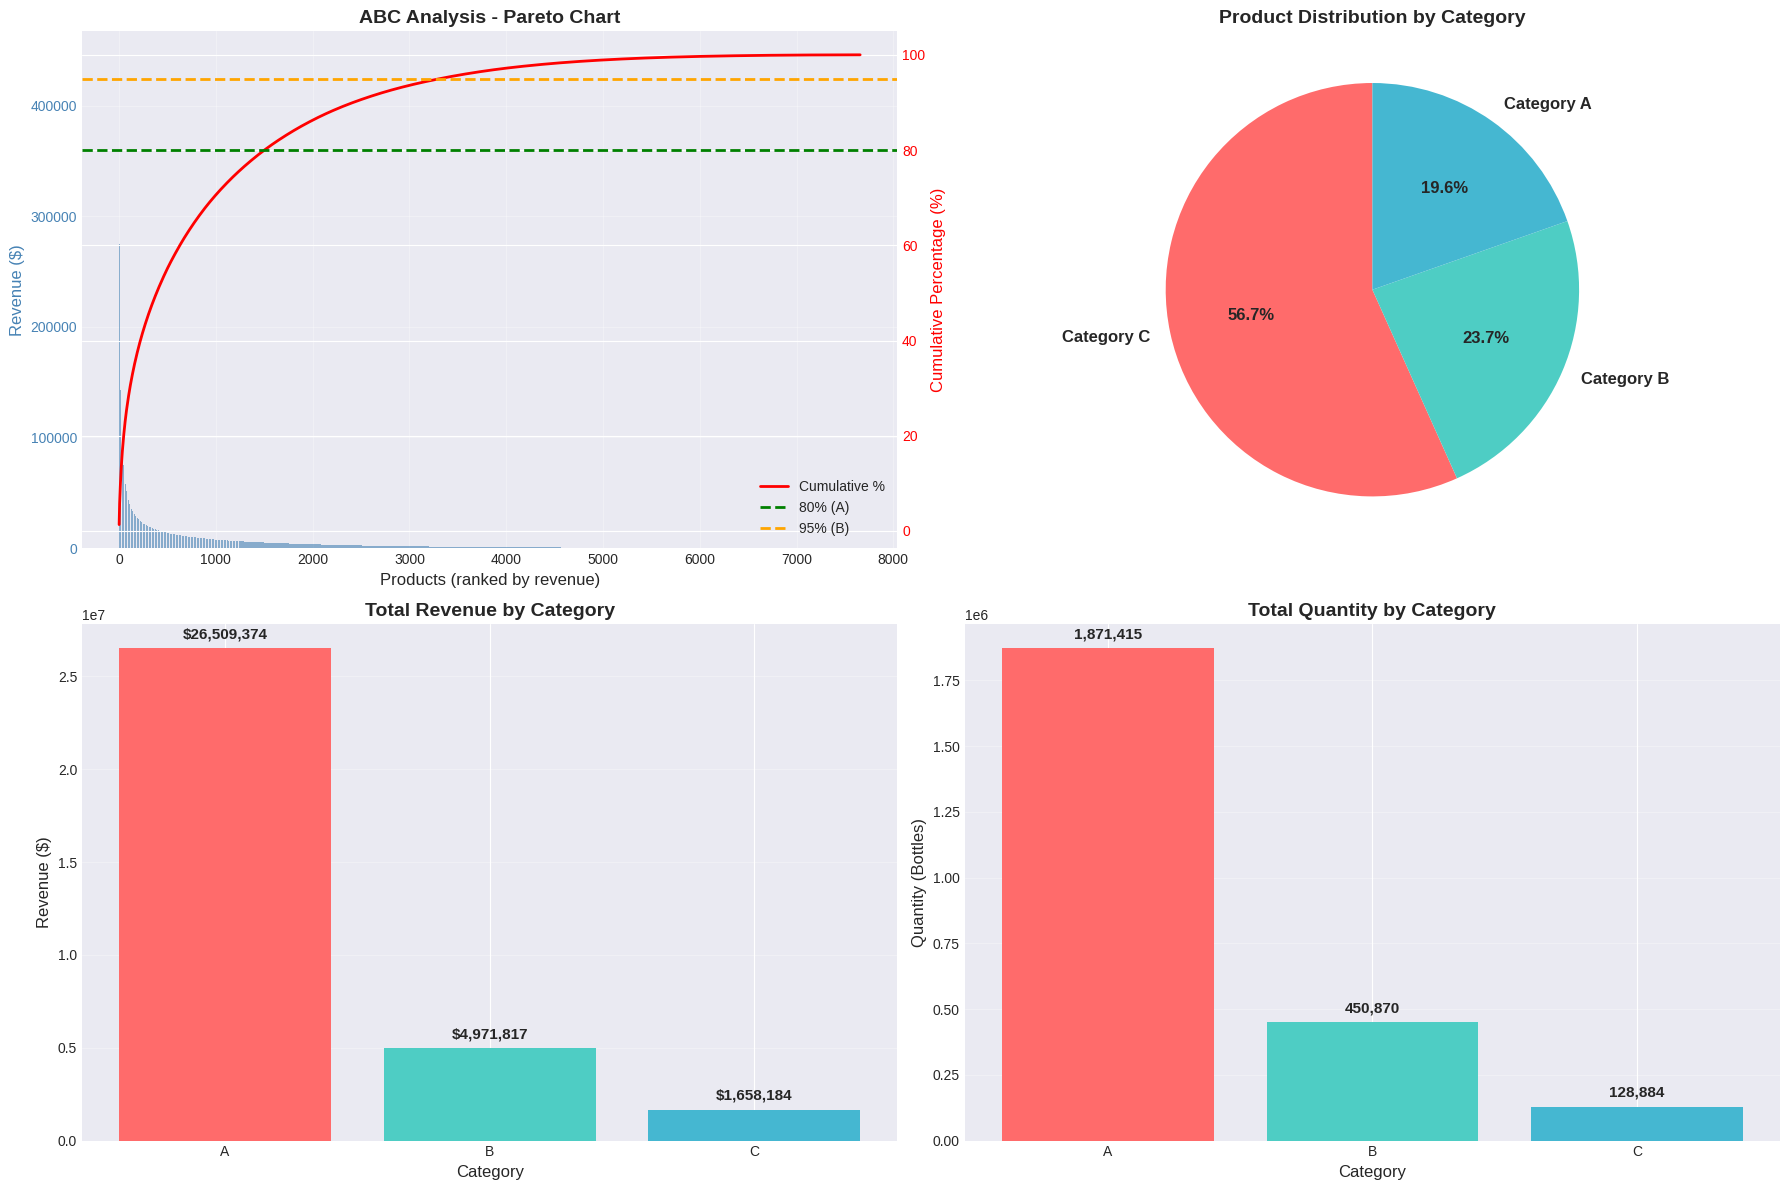


 ABC analysis saved to 'abc_analysis.csv'


In [8]:
if 'SalesDollars' in sales_df.columns and 'SalesQuantity' in sales_df.columns:
    sales_df['unit_price'] = sales_df['SalesDollars'] / sales_df['SalesQuantity']
    revenue_col = 'SalesDollars'
else:
    revenue_col = price_col

product_revenue = sales_df.groupby(product_col).agg({
    quantity_col: 'sum',
    revenue_col: 'sum'
}).reset_index()

product_revenue.columns = ['product', 'total_quantity', 'total_revenue']
product_revenue = product_revenue.sort_values('total_revenue', ascending=False).reset_index(drop=True)

# Calculate cumulative percentage
product_revenue['cumulative_revenue'] = product_revenue['total_revenue'].cumsum()
product_revenue['cumulative_pct'] = (product_revenue['cumulative_revenue'] /
                                      product_revenue['total_revenue'].sum()) * 100

# ABC Classification
def classify_abc(pct):
    if pct <= 80:
        return 'A'
    elif pct <= 95:
        return 'B'
    else:
        return 'C'

product_revenue['abc_category'] = product_revenue['cumulative_pct'].apply(classify_abc)

# Calculate average price
product_revenue['avg_price'] = product_revenue['total_revenue'] / product_revenue['total_quantity']

# Summary
print("=" * 60)
print("ABC ANALYSIS SUMMARY".center(60))
print("=" * 60)

summary = product_revenue.groupby('abc_category').agg({
    'product': 'count',
    'total_revenue': 'sum',
    'total_quantity': 'sum'
}).rename(columns={'product': 'num_products'})

summary['revenue_pct'] = (summary['total_revenue'] / summary['total_revenue'].sum()) * 100
summary['quantity_pct'] = (summary['total_quantity'] / summary['total_quantity'].sum()) * 100

print(summary)
print("=" * 60)

# Show top products in each category
for category in ['A', 'B', 'C']:
    print(f"\nTOP 5 CATEGORY {category} PRODUCTS:")
    top_cat = product_revenue[product_revenue['abc_category']==category].head()
    print(top_cat[['product', 'total_quantity', 'total_revenue', 'cumulative_pct']])

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Pareto Chart
ax1 = axes[0, 0]
ax1.bar(range(len(product_revenue)), product_revenue['total_revenue'],
        alpha=0.6, color='steelblue', label='Revenue')
ax1.set_xlabel("Products (ranked by revenue)", fontsize=12)
ax1.set_ylabel("Revenue ($)", fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(range(len(product_revenue)), product_revenue['cumulative_pct'],
         color='red', linewidth=2, label='Cumulative %')
ax2.axhline(y=80, color='green', linestyle='--', linewidth=2, label='80% (A)')
ax2.axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95% (B)')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='lower right', fontsize=10)

ax1.set_title("ABC Analysis - Pareto Chart", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Pie Chart - Products
category_counts = product_revenue['abc_category'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
axes[0, 1].pie(category_counts, labels=[f'Category {x}' for x in category_counts.index],
               autopct='%1.1f%%', colors=colors, startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 1].set_title("Product Distribution by Category", fontsize=14, fontweight='bold')

# Bar Chart - Revenue by Category
revenue_by_cat = product_revenue.groupby('abc_category')['total_revenue'].sum()
axes[1, 0].bar(revenue_by_cat.index, revenue_by_cat.values, color=colors)
axes[1, 0].set_title("Total Revenue by Category", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Category", fontsize=12)
axes[1, 0].set_ylabel("Revenue ($)", fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(revenue_by_cat.values):
    axes[1, 0].text(i, v + max(revenue_by_cat.values)*0.02,
                    f'${v:,.0f}', ha='center', fontweight='bold', fontsize=11)

# Bar Chart - Quantity by Category
quantity_by_cat = product_revenue.groupby('abc_category')['total_quantity'].sum()
axes[1, 1].bar(quantity_by_cat.index, quantity_by_cat.values, color=colors)
axes[1, 1].set_title("Total Quantity by Category", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Category", fontsize=12)
axes[1, 1].set_ylabel("Quantity (Bottles)", fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(quantity_by_cat.values):
    axes[1, 1].text(i, v + max(quantity_by_cat.values)*0.02,
                    f'{v:,.0f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Save ABC analysis
product_revenue.to_csv('abc_analysis.csv', index=False)
print("\n ABC analysis saved to 'abc_analysis.csv'")

Calculating inventory metrics for all products...

                INVENTORY OPTIMIZATION METRICS - TOP 15 PRODUCTS                
    product abc_category  annual_demand  daily_demand    eoq   rop  \
0        58            B            288      0.789041  163.0   9.0   
1        60            B            124      0.339726  117.0   4.0   
2        61            C             24      0.065753   36.0   1.0   
3        62            A            162      0.443836   73.0   4.0   
4        63            A            131      0.358904   64.0   3.0   
5        72            C             19      0.052055   19.0   1.0   
6        75            C              3      0.008219   12.0   0.0   
7        77            A            908      2.487671  304.0  20.0   
8        79            A            416      1.139726  192.0   9.0   
9        82            C              3      0.008219    2.0   0.0   
10       86            C              1      0.002740    2.0   0.0   
11      100            C    

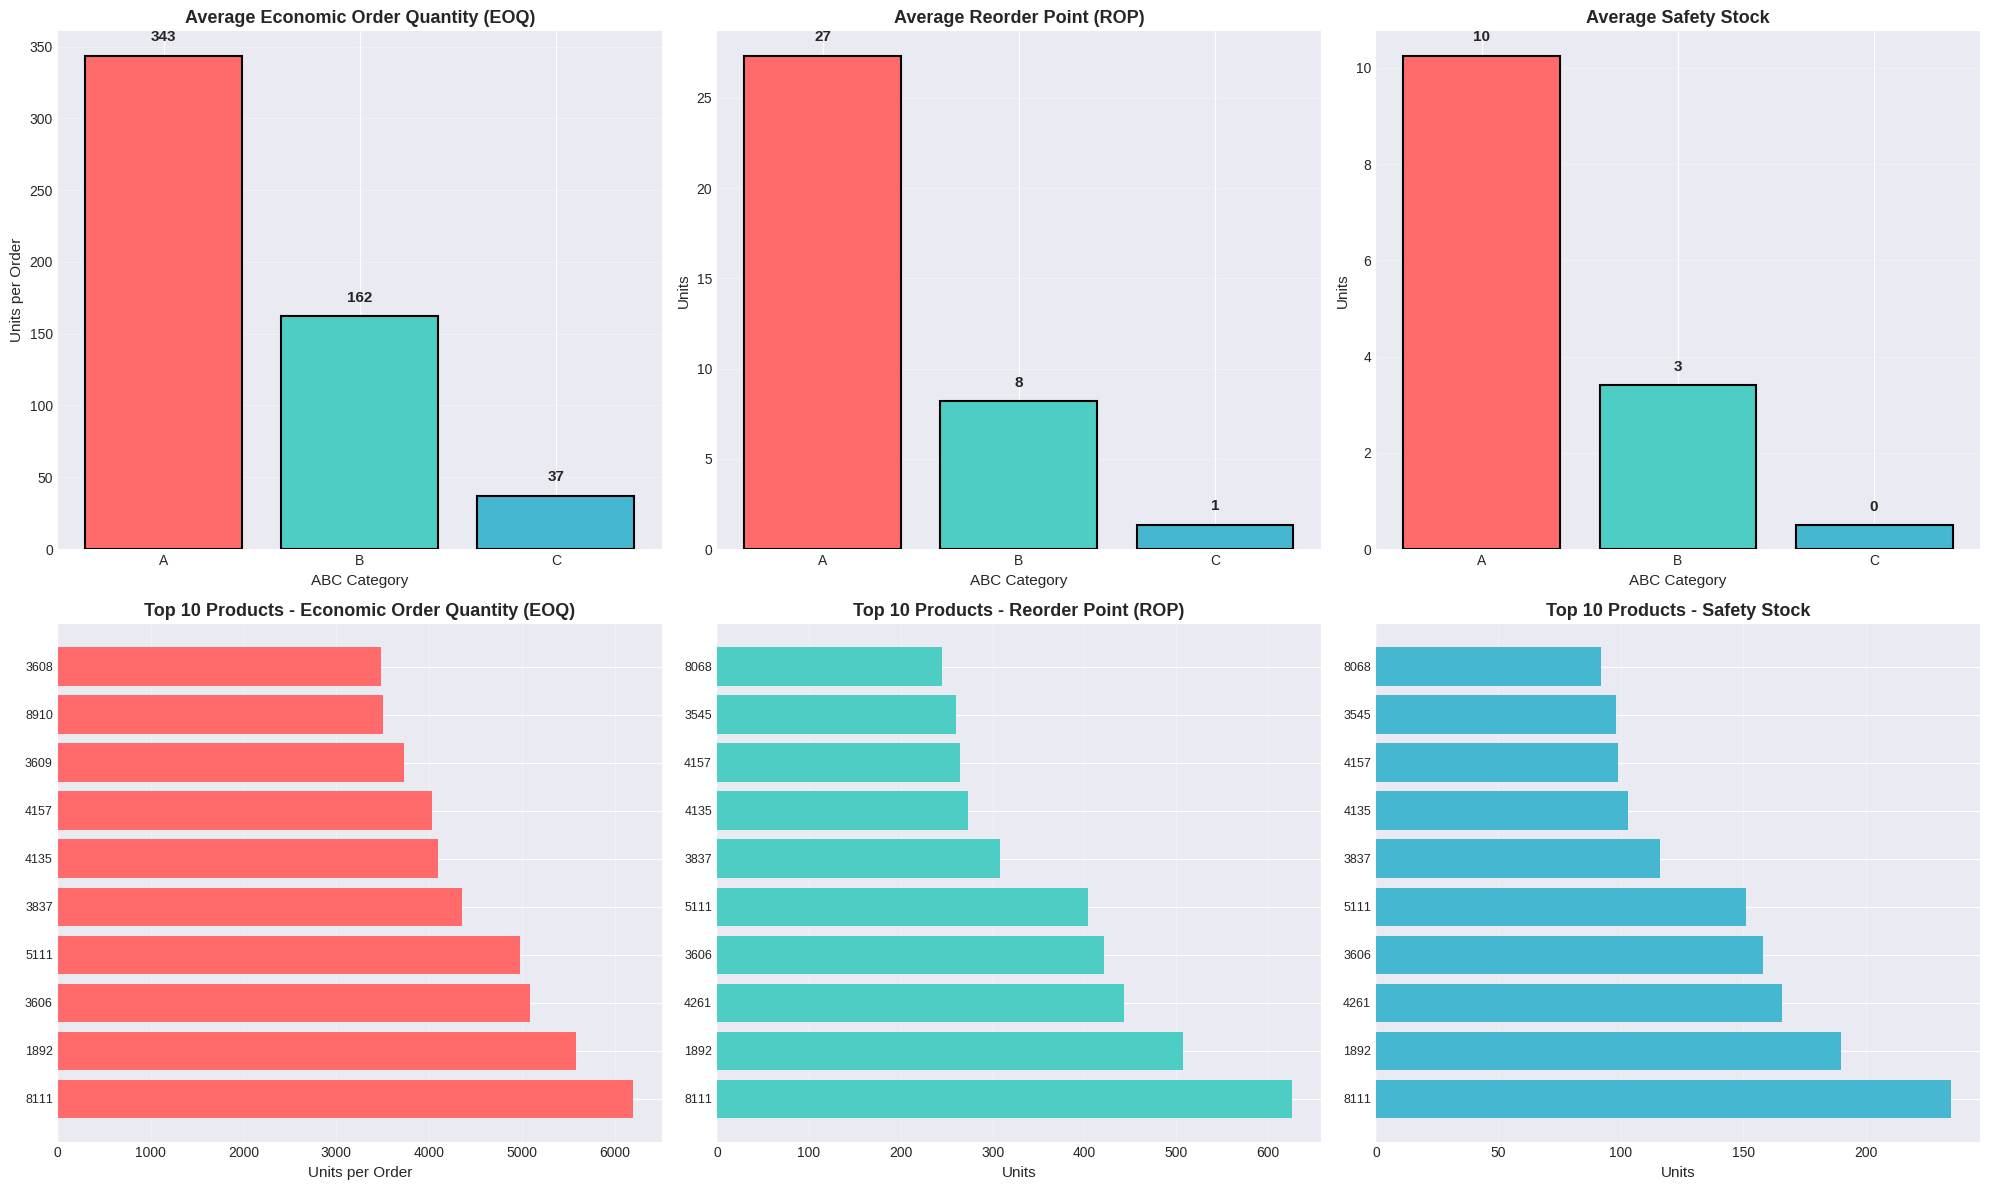


 KEY INSIGHTS:
   Total unique products: 7,658
   Category A products: 1,502
   Category B products: 1,813
   Category C products: 4,343

   Average EOQ across all products: 127 units
   Average ROP across all products: 8 units
   Total safety stock needed: 23,690 units

 Inventory optimization metrics saved to 'inventory_optimization.csv'


In [9]:
# Calculate annual demand per product
annual_demand = sales_df.groupby(product_col)[quantity_col].sum().reset_index()
annual_demand.columns = ['product', 'annual_demand']

# Merge with ABC category
inventory_metrics = annual_demand.merge(
    product_revenue[['product', 'abc_category', 'total_revenue', 'avg_price']],
    on='product'
)

# Functions
def calculate_eoq(annual_demand, ordering_cost=100, holding_pct=0.20, unit_cost=10):
    """
    Economic Order Quantity Formula:
    EOQ = sqrt((2 * D * S) / H)
    where D = annual demand, S = ordering cost, H = holding cost per unit
    """
    holding_cost = unit_cost * holding_pct
    return np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)

def calculate_rop(daily_demand, lead_time=7, safety_days=3):
    """
    Reorder Point Formula:
    ROP = (Daily Demand × Lead Time) + Safety Stock
    """
    return (daily_demand * lead_time) + (daily_demand * safety_days)

# Calculate daily demand
inventory_metrics['daily_demand'] = inventory_metrics['annual_demand'] / 365

# Category-specific parameters for wine & spirits retail
params = {
    'A': {
        'ordering_cost': 200,      # Higher ordering cost for premium products
        'holding_pct': 0.30,       # 30% holding cost
        'unit_cost': 100,          # Average cost for Category A
        'lead_time': 5,            # Days
        'safety_days': 3           # Safety stock days
    },
    'B': {
        'ordering_cost': 150,
        'holding_pct': 0.25,
        'unit_cost': 50,
        'lead_time': 7,
        'safety_days': 5
    },
    'C': {
        'ordering_cost': 75,
        'holding_pct': 0.20,
        'unit_cost': 20,
        'lead_time': 10,
        'safety_days': 7
    }
}

# Calculate EOQ and ROP for each product
print("Calculating inventory metrics for all products...")
for idx, row in inventory_metrics.iterrows():
    p = params[row['abc_category']]

    # Use actual average price if available, otherwise use category default
    actual_unit_cost = row['avg_price'] if row['avg_price'] > 0 else p['unit_cost']

    inventory_metrics.at[idx, 'eoq'] = calculate_eoq(
        row['annual_demand'],
        p['ordering_cost'],
        p['holding_pct'],
        actual_unit_cost
    )

    inventory_metrics.at[idx, 'rop'] = calculate_rop(
        row['daily_demand'],
        p['lead_time'],
        p['safety_days']
    )

    inventory_metrics.at[idx, 'safety_stock'] = row['daily_demand'] * p['safety_days']
    inventory_metrics.at[idx, 'lead_time_days'] = p['lead_time']

# Round values
inventory_metrics[['eoq', 'rop', 'safety_stock']] = inventory_metrics[['eoq', 'rop', 'safety_stock']].round(0)

print("\n" + "=" * 80)
print("INVENTORY OPTIMIZATION METRICS - TOP 15 PRODUCTS".center(80))
print("=" * 80)
print(inventory_metrics.head(15)[['product', 'abc_category', 'annual_demand', 'daily_demand', 'eoq', 'rop', 'safety_stock']])

print("\n" + "=" * 80)
print("AVERAGE METRICS BY ABC CATEGORY".center(80))
print("=" * 80)
category_avg = inventory_metrics.groupby('abc_category')[['annual_demand', 'daily_demand', 'eoq', 'rop', 'safety_stock']].mean().round(0)
print(category_avg)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
metrics = [
    ('eoq', 'Economic Order Quantity (EOQ)', 'Units per Order'),
    ('rop', 'Reorder Point (ROP)', 'Units'),
    ('safety_stock', 'Safety Stock', 'Units')
]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

# Top row: Bar charts by category
for idx, (metric, title, ylabel) in enumerate(metrics):
    avg = inventory_metrics.groupby('abc_category')[metric].mean()
    axes[0, idx].bar(avg.index, avg.values, color=colors, edgecolor='black', linewidth=1.5)
    axes[0, idx].set_title(f"Average {title}", fontsize=13, fontweight='bold')
    axes[0, idx].set_xlabel("ABC Category", fontsize=11)
    axes[0, idx].set_ylabel(ylabel, fontsize=11)
    axes[0, idx].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, v in enumerate(avg.values):
        axes[0, idx].text(i, v + max(avg.values)*0.03, f'{v:.0f}',
                         ha='center', fontweight='bold', fontsize=11)

# Bottom row: Top 10 products for each metric
for idx, (metric, title, ylabel) in enumerate(metrics):
    top_10 = inventory_metrics.nlargest(10, metric)
    axes[1, idx].barh(range(len(top_10)), top_10[metric].values, color=colors[idx])
    axes[1, idx].set_yticks(range(len(top_10)))
    axes[1, idx].set_yticklabels(top_10['product'].values, fontsize=9)
    axes[1, idx].set_title(f"Top 10 Products - {title}", fontsize=13, fontweight='bold')
    axes[1, idx].set_xlabel(ylabel, fontsize=11)
    axes[1, idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Additional insights
print("\n KEY INSIGHTS:")
print(f"   Total unique products: {len(inventory_metrics):,}")
print(f"   Category A products: {len(inventory_metrics[inventory_metrics['abc_category']=='A']):,}")
print(f"   Category B products: {len(inventory_metrics[inventory_metrics['abc_category']=='B']):,}")
print(f"   Category C products: {len(inventory_metrics[inventory_metrics['abc_category']=='C']):,}")
print(f"\n   Average EOQ across all products: {inventory_metrics['eoq'].mean():,.0f} units")
print(f"   Average ROP across all products: {inventory_metrics['rop'].mean():,.0f} units")
print(f"   Total safety stock needed: {inventory_metrics['safety_stock'].sum():,.0f} units")

# Save inventory metrics
inventory_metrics.to_csv('inventory_optimization.csv', index=False)
print("\n Inventory optimization metrics saved to 'inventory_optimization.csv'")

                             PURCHASE DATA ANALYSIS                             

Shape: (2372474, 16)
Columns: ['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber', 'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification']

 Sample Data:
           InventoryId  Store  Brand                   Description   Size  \
0    69_MOUNTMEND_8412     69   8412     Tequila Ocho Plata Fresno  750mL   
1     30_CULCHETH_5255     30   5255  TGI Fridays Ultimte Mudslide  1.75L   
2    34_PITMERDEN_5215     34   5215  TGI Fridays Long Island Iced  1.75L   
3  1_HARDERSFIELD_5255      1   5255  TGI Fridays Ultimte Mudslide  1.75L   
4    76_DONCASTER_2034     76   2034     Glendalough Double Barrel  750mL   

   VendorNumber                   VendorName  PONumber      PODate  \
0           105  ALTAMAR BRANDS LLC               8124  2015-12-21   
1          4466  AMERICAN VINTAGE BEVERAGE        8137  2015

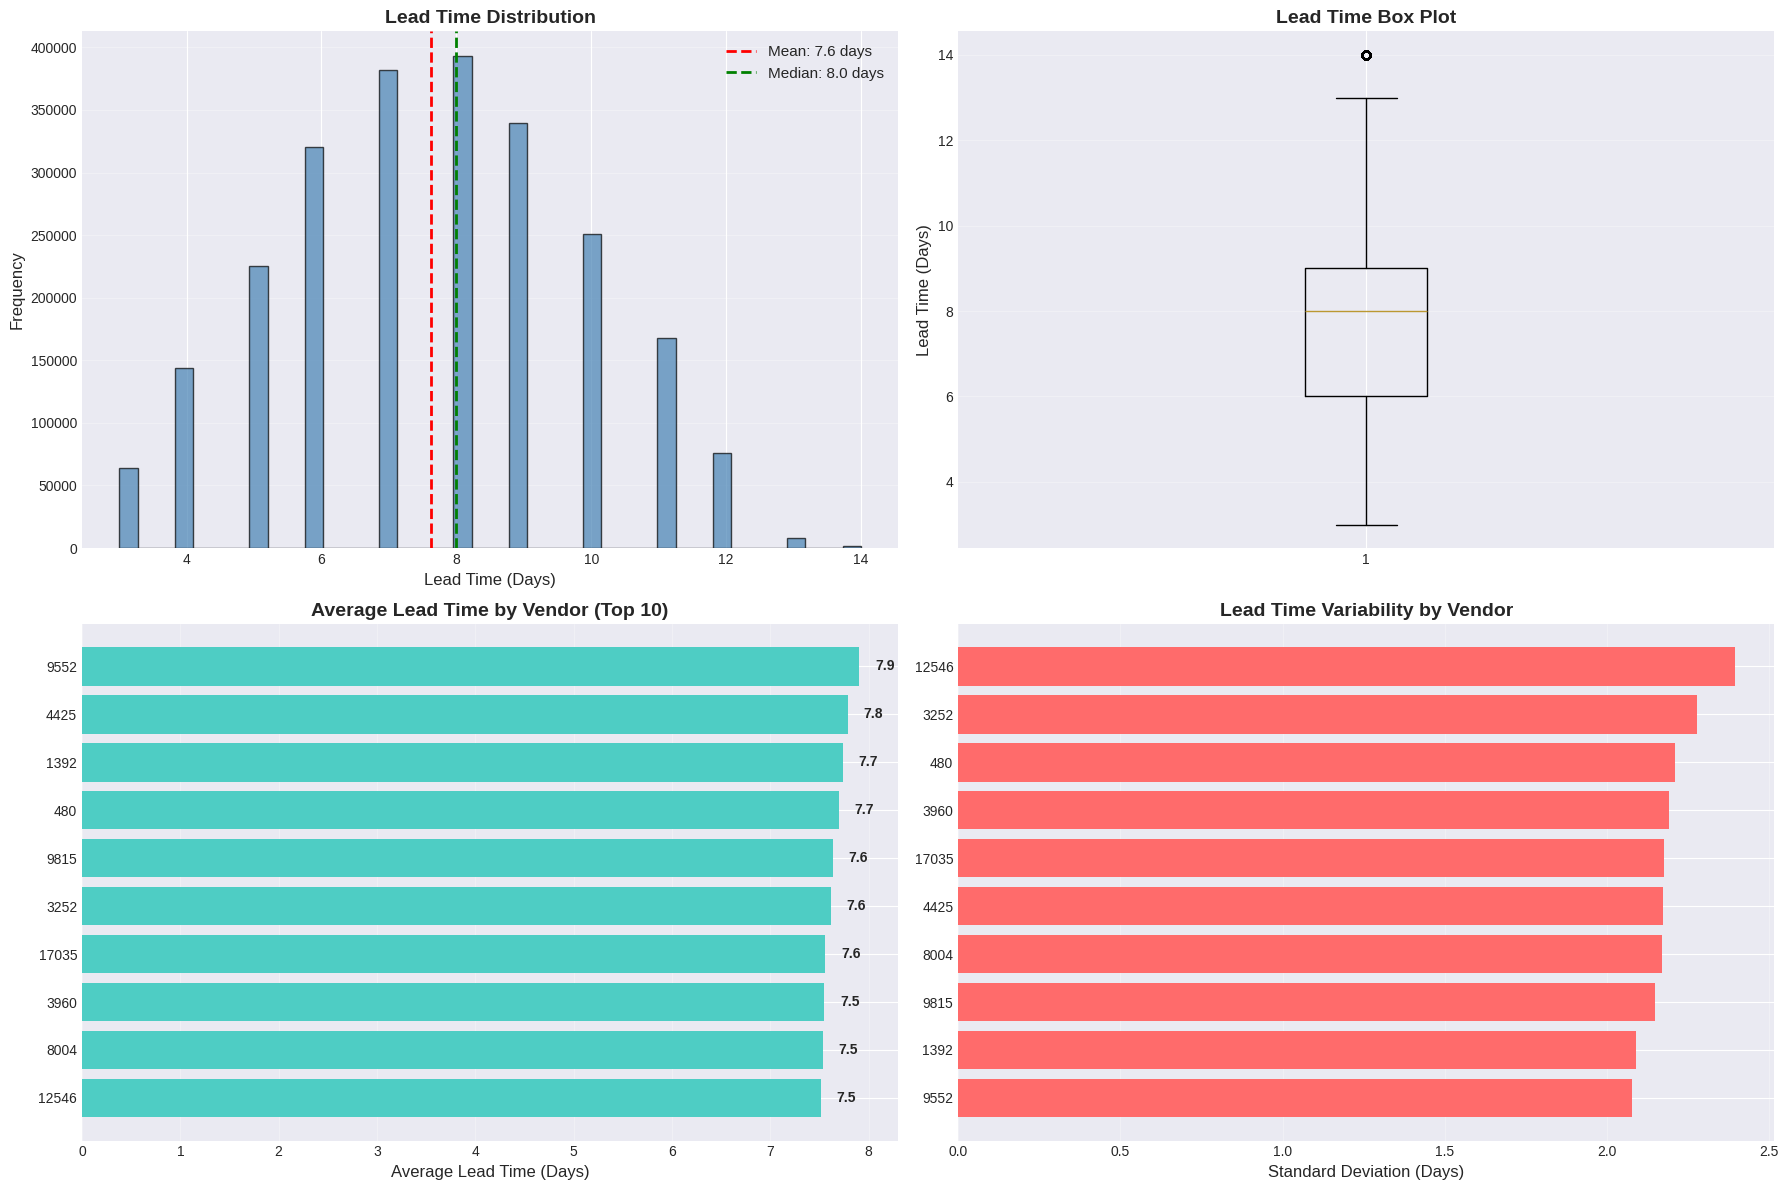


                        KEY INSIGHTS                        
   Average lead time: 7.6 days
   Median lead time: 8.0 days
   Standard deviation: 2.2 days
   90th percentile: 11.0 days
   Total purchase orders analyzed: 2,372,474

 Supplier lead time analysis saved to 'supplier_lead_times.csv'


In [10]:
# Analyze purchases data for lead time
print("=" * 80)
print("PURCHASE DATA ANALYSIS".center(80))
print("=" * 80)
print(f"\nShape: {purchases_df.shape}")
print(f"Columns: {purchases_df.columns.tolist()}")
print("\n Sample Data:")
print(purchases_df.head())

# Check for date columns in purchases
purchase_date_cols = [col for col in purchases_df.columns if 'date' in col.lower()]
print(f"\n Date columns found: {purchase_date_cols}")

# Check for vendor/supplier columns
vendor_cols = [col for col in purchases_df.columns if any(x in col.lower() for x in ['vendor', 'supplier'])]
print(f" Vendor columns found: {vendor_cols}")

# If we have multiple date columns, calculate lead time
if len(purchase_date_cols) >= 2:
    # Assuming first is order date, second is delivery date
    order_date_col = purchase_date_cols[0]
    delivery_date_col = purchase_date_cols[1] if len(purchase_date_cols) > 1 else purchase_date_cols[0]

    print(f"\n Calculating lead time using:")
    print(f"   Order Date: {order_date_col}")
    print(f"   Delivery Date: {delivery_date_col}")

    # Convert to datetime
    purchases_df[order_date_col] = pd.to_datetime(purchases_df[order_date_col])
    purchases_df[delivery_date_col] = pd.to_datetime(purchases_df[delivery_date_col])

    # Calculate lead time
    purchases_df['lead_time_days'] = (purchases_df[delivery_date_col] - purchases_df[order_date_col]).dt.days

    # Remove negative/outlier values
    valid_purchases = purchases_df[(purchases_df['lead_time_days'] >= 0) &
                                    (purchases_df['lead_time_days'] <= 90)]

    print("\n" + "=" * 60)
    print("LEAD TIME STATISTICS".center(60))
    print("=" * 60)
    print(valid_purchases['lead_time_days'].describe())

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Lead time distribution
    axes[0, 0].hist(valid_purchases['lead_time_days'], bins=40,
                    edgecolor='black', color='steelblue', alpha=0.7)
    axes[0, 0].axvline(valid_purchases['lead_time_days'].mean(),
                       color='red', linestyle='--', linewidth=2, label=f"Mean: {valid_purchases['lead_time_days'].mean():.1f} days")
    axes[0, 0].axvline(valid_purchases['lead_time_days'].median(),
                       color='green', linestyle='--', linewidth=2, label=f"Median: {valid_purchases['lead_time_days'].median():.1f} days")
    axes[0, 0].set_title("Lead Time Distribution", fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel("Lead Time (Days)", fontsize=12)
    axes[0, 0].set_ylabel("Frequency", fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Box plot
    axes[0, 1].boxplot(valid_purchases['lead_time_days'], vert=True)
    axes[0, 1].set_title("Lead Time Box Plot", fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel("Lead Time (Days)", fontsize=12)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # By vendor if available
    if vendor_cols:
        vendor_col = vendor_cols[0]

        # Top 10 vendors by volume
        top_vendors = valid_purchases[vendor_col].value_counts().head(10).index
        vendor_lead = valid_purchases[valid_purchases[vendor_col].isin(top_vendors)].groupby(vendor_col)['lead_time_days'].mean().sort_values()

        axes[1, 0].barh(range(len(vendor_lead)), vendor_lead.values, color='#4ecdc4')
        axes[1, 0].set_yticks(range(len(vendor_lead)))
        axes[1, 0].set_yticklabels(vendor_lead.index, fontsize=10)
        axes[1, 0].set_title("Average Lead Time by Vendor (Top 10)", fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel("Average Lead Time (Days)", fontsize=12)
        axes[1, 0].grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, v in enumerate(vendor_lead.values):
            axes[1, 0].text(v + max(vendor_lead.values)*0.02, i, f'{v:.1f}',
                           va='center', fontweight='bold', fontsize=10)

        # Lead time variability by vendor
        vendor_std = valid_purchases[valid_purchases[vendor_col].isin(top_vendors)].groupby(vendor_col)['lead_time_days'].std().sort_values()

        axes[1, 1].barh(range(len(vendor_std)), vendor_std.values, color='#ff6b6b')
        axes[1, 1].set_yticks(range(len(vendor_std)))
        axes[1, 1].set_yticklabels(vendor_std.index, fontsize=10)
        axes[1, 1].set_title("Lead Time Variability by Vendor", fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel("Standard Deviation (Days)", fontsize=12)
        axes[1, 1].grid(True, alpha=0.3, axis='x')

        print(f"\n VENDOR PERFORMANCE (Top 10 by volume):")
        vendor_analysis = valid_purchases[valid_purchases[vendor_col].isin(top_vendors)].groupby(vendor_col)['lead_time_days'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(1)
        vendor_analysis.columns = ['Orders', 'Avg Lead Time', 'Median', 'Std Dev', 'Min', 'Max']
        print(vendor_analysis.sort_values('Avg Lead Time'))
    else:
        # If no vendor column, show monthly trend
        valid_purchases['order_month'] = valid_purchases[order_date_col].dt.to_period('M')
        monthly_lead = valid_purchases.groupby('order_month')['lead_time_days'].mean()

        axes[1, 0].plot(monthly_lead.index.astype(str), monthly_lead.values,
                       marker='o', linewidth=2, markersize=8, color='#4ecdc4')
        axes[1, 0].set_title("Monthly Average Lead Time", fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel("Month", fontsize=12)
        axes[1, 0].set_ylabel("Average Lead Time (Days)", fontsize=12)
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Key insights
    print("\n" + "=" * 60)
    print("KEY INSIGHTS".center(60))
    print("=" * 60)
    print(f"   Average lead time: {valid_purchases['lead_time_days'].mean():.1f} days")
    print(f"   Median lead time: {valid_purchases['lead_time_days'].median():.1f} days")
    print(f"   Standard deviation: {valid_purchases['lead_time_days'].std():.1f} days")
    print(f"   90th percentile: {valid_purchases['lead_time_days'].quantile(0.90):.1f} days")
    print(f"   Total purchase orders analyzed: {len(valid_purchases):,}")

    # Save lead time analysis
    if vendor_cols:
        vendor_analysis.to_csv('supplier_lead_times.csv')
        print("\n Supplier lead time analysis saved to 'supplier_lead_times.csv'")

else:
    print("\n Not enough date columns to calculate lead time")
    print("Available date columns:", purchase_date_cols)

                     PREPARING DATA FOR DEMAND FORECASTING                      

 Time Series Summary:
   Total days: 60
   Date range: 2016-01-01 00:00:00 to 2016-02-29 00:00:00
   Total quantity: 2,451,169
   Average daily sales: 40,853
   Max daily sales: 180,426
   Min daily sales: 5,425


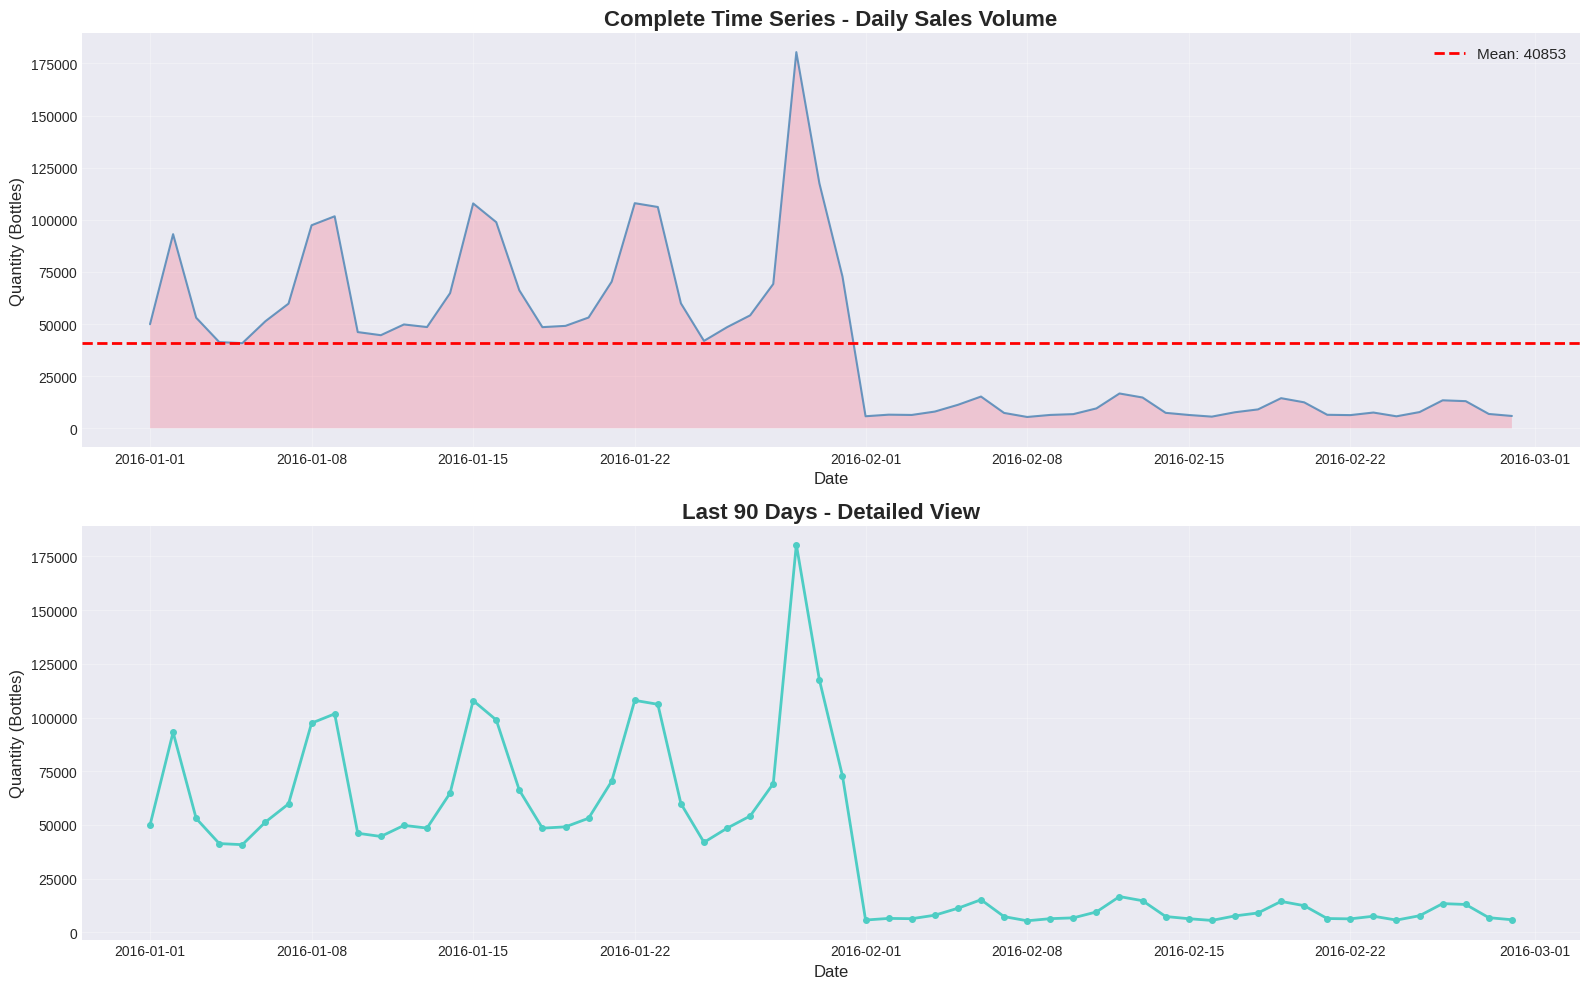


 Scaling data for neural network...

 Sequences created:
   Input shape: (30, 30, 1)
   Output shape: (30,)
   Lookback period: 30 days

 Data Split:
   Training samples: 24
   Testing samples: 6
   Training period: 24 days
   Testing period: 6 days

 Data preparation complete!


In [22]:
# Prepare data for time series forecasting
print("=" * 80)
print("PREPARING DATA FOR DEMAND FORECASTING".center(80))
print("=" * 80)

# Use the date and quantity columns identified earlier
daily_sales_ts = sales_df.groupby(date_col)[quantity_col].sum().reset_index()
daily_sales_ts.columns = ['date', 'quantity']
daily_sales_ts = daily_sales_ts.sort_values('date').reset_index(drop=True)

print(f"\n Time Series Summary:")
print(f"   Total days: {len(daily_sales_ts)}")
print(f"   Date range: {daily_sales_ts['date'].min()} to {daily_sales_ts['date'].max()}")
print(f"   Total quantity: {daily_sales_ts['quantity'].sum():,.0f}")
print(f"   Average daily sales: {daily_sales_ts['quantity'].mean():,.0f}")
print(f"   Max daily sales: {daily_sales_ts['quantity'].max():,.0f}")
print(f"   Min daily sales: {daily_sales_ts['quantity'].min():,.0f}")

# Visualize time series
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full time series
axes[0].plot(daily_sales_ts['date'], daily_sales_ts['quantity'],
            linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].axhline(daily_sales_ts['quantity'].mean(), color='red',
               linestyle='--', linewidth=2, label=f"Mean: {daily_sales_ts['quantity'].mean():.0f}")
axes[0].fill_between(daily_sales_ts['date'], daily_sales_ts['quantity'], alpha=0.3)
axes[0].set_title("Complete Time Series - Daily Sales Volume", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Quantity (Bottles)", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Decomposition view (last 90 days)
recent_data = daily_sales_ts.tail(90)
axes[1].plot(recent_data['date'], recent_data['quantity'],
            linewidth=2, color='#4ecdc4', marker='o', markersize=4)
axes[1].set_title("Last 90 Days - Detailed View", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Quantity (Bottles)", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scale data for LSTM
print("\n Scaling data for neural network...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sales_ts[['quantity']])

# Create sequences for LSTM
def create_sequences(data, lookback=60):
    """
    Create sequences for time series prediction
    lookback: number of previous time steps to use as input
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 30
X, y = create_sequences(scaled_data, lookback)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"\n Sequences created:")
print(f"   Input shape: {X.shape}")
print(f"   Output shape: {y.shape}")
print(f"   Lookback period: {lookback} days")

# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\n Data Split:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Testing samples: {len(X_test):,}")
print(f"   Training period: {len(X_train)} days")
print(f"   Testing period: {len(X_test)} days")

print("\n Data preparation complete!")

                   BUILDING LSTM MODEL FOR DEMAND FORECASTING                   

 Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,833 (1.96 MB)

 Trainable params: 512,833 (1.96 MB)

 Non-trainable params: 0 (0.00 B)


 Training started...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.0071 - mae: 0.0377 - val_loss: 3.6655e-04 - val_mae: 0.0187
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0058 - mae: 0.0501 - val_loss: 3.4006e-04 - val_mae: 0.0162
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0058 - mae: 0.0435 - val_loss: 3.6494e-04 - val_mae: 0.0150
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0057 - mae: 0.0381 - val_loss: 3.9443e-04 - val_mae: 0.0147
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0062 - mae: 0.0350 - val_loss: 3.8428e-04 - val_mae: 0.0147
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0056 - mae: 0.0371 - val_loss: 3.7335e-04 - val_mae: 0.0148
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0054 - mae: 0.0399 - val_loss: 3.6447e-04 - val_mae: 0.0152
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0058 - mae: 0.0396 - val_loss: 3.7130e-04 - val_mae: 0.0150
Epoch 9/50
1/1 ━━━━━━

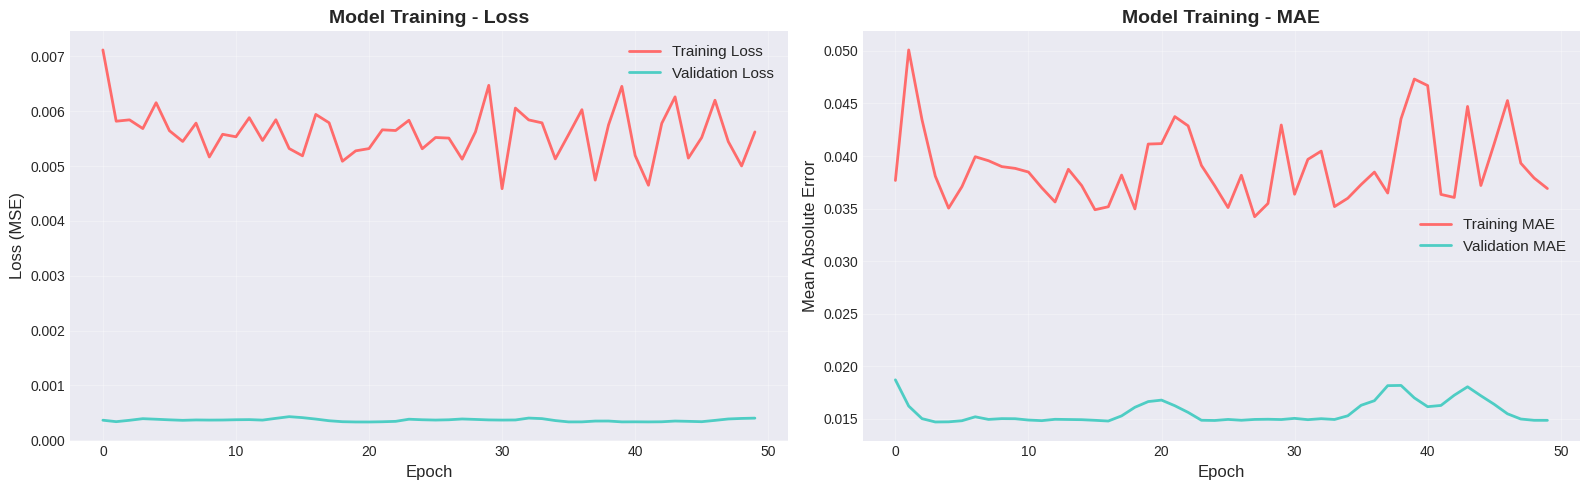


 Model saved as 'demand_forecast_model.keras'


In [25]:
# Build LSTM model
print("=" * 80)
print("BUILDING LSTM MODEL FOR DEMAND FORECASTING".center(80))
print("=" * 80)

model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("\n Model Architecture:")
model.summary()

# Train the model
print("\n Training started...")
print("=" * 80)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False  # Important for time series
)

print("\n Training complete!")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#ff6b6b')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#4ecdc4')
axes[0].set_title("Model Training - Loss", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss (MSE)", fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='#ff6b6b')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='#4ecdc4')
axes[1].set_title("Model Training - MAE", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Mean Absolute Error", fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the model
model.save('demand_forecast_model.keras')
print("\n Model saved as 'demand_forecast_model.keras'")

                                MODEL EVALUATION                                

 PERFORMANCE METRICS:
   Mean Absolute Error (MAE): 2602.60 bottles
   Root Mean Squared Error (RMSE): 3518.79 bottles
   Mean Absolute Percentage Error (MAPE): 25.56%
   R² Score: -0.2070

 ACCURACY INSIGHTS:
   Average actual demand: 8786 bottles/day
   Average predicted demand: 7385 bottles/day
   Prediction accuracy: 74.44%


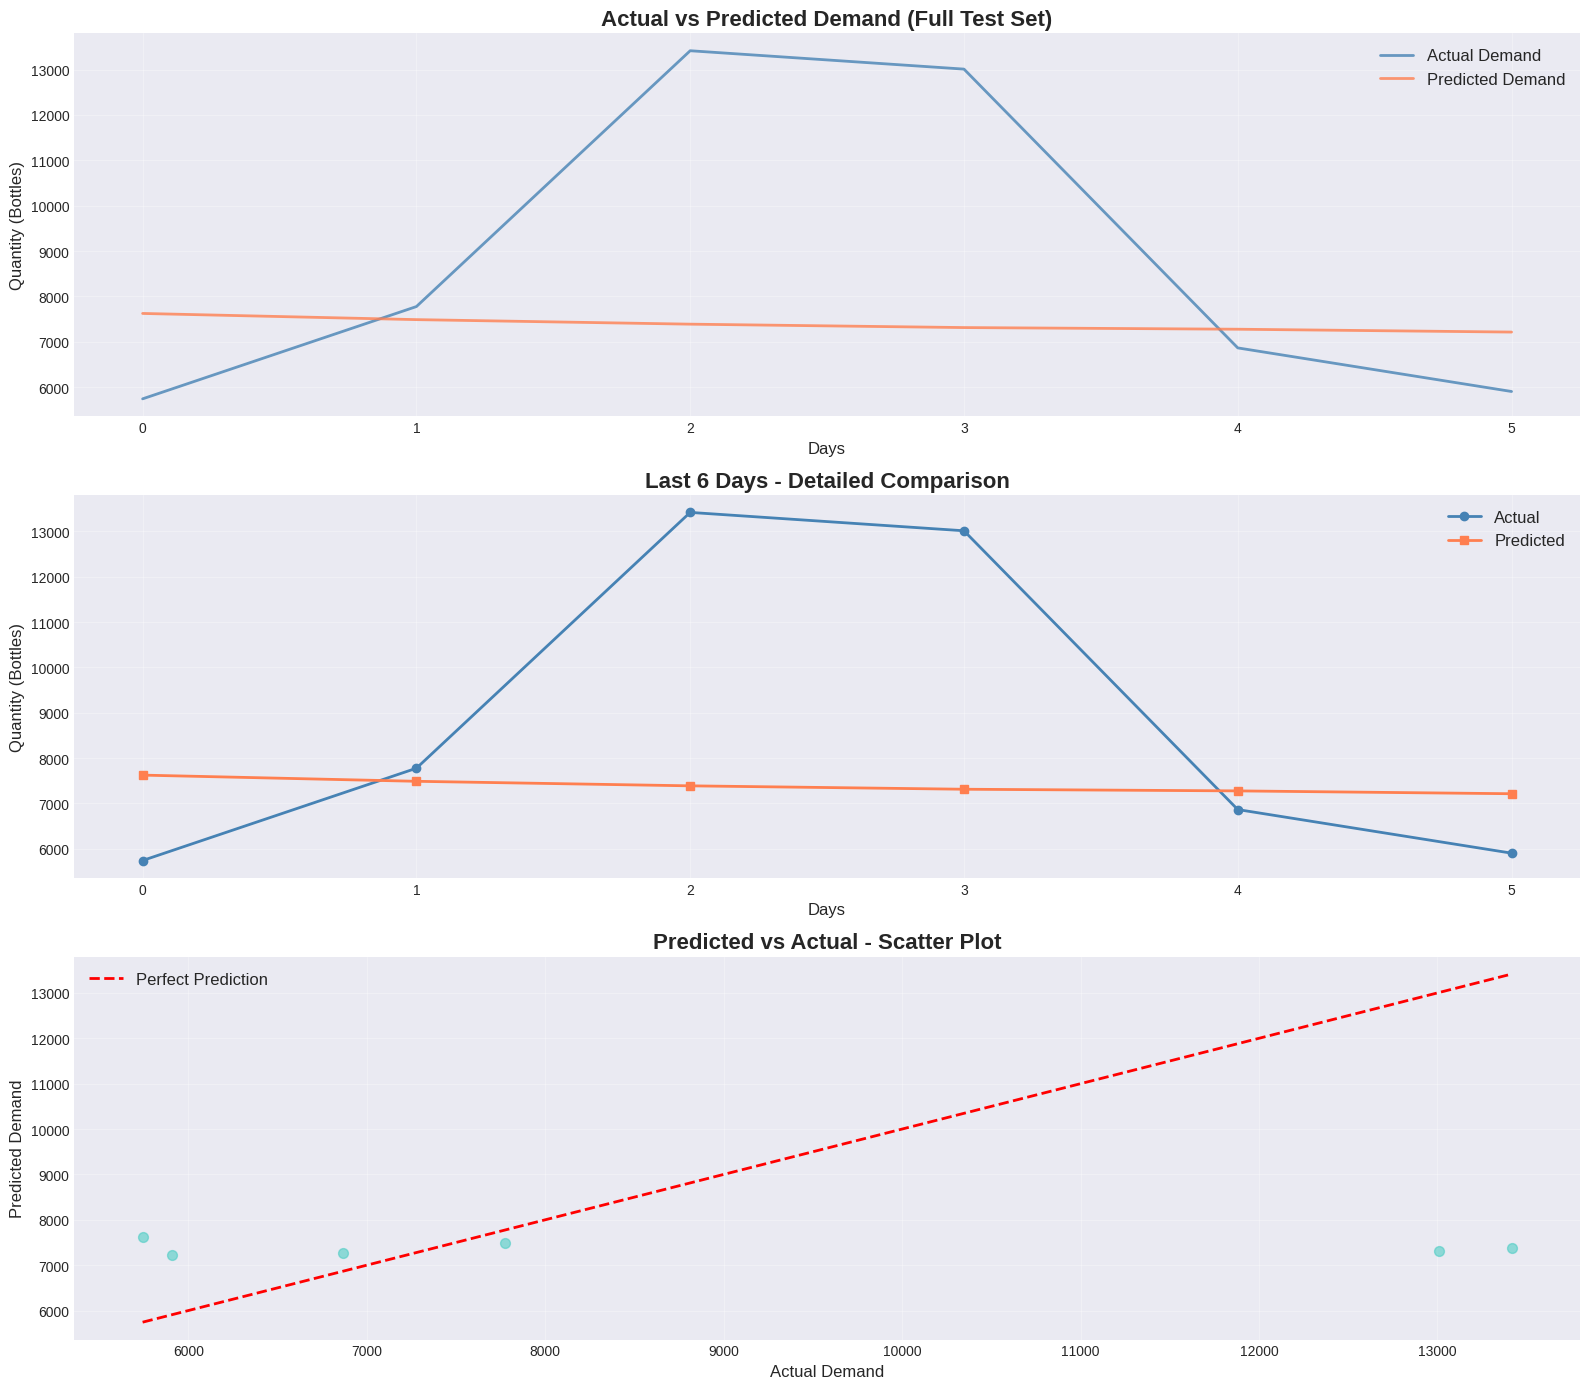


 ERROR ANALYSIS:
   Mean Error: -1401.33 bottles
   Error Std Dev: 3227.71 bottles
   Max Overestimation: 1882.32 bottles
   Max Underestimation: -6026.94 bottles


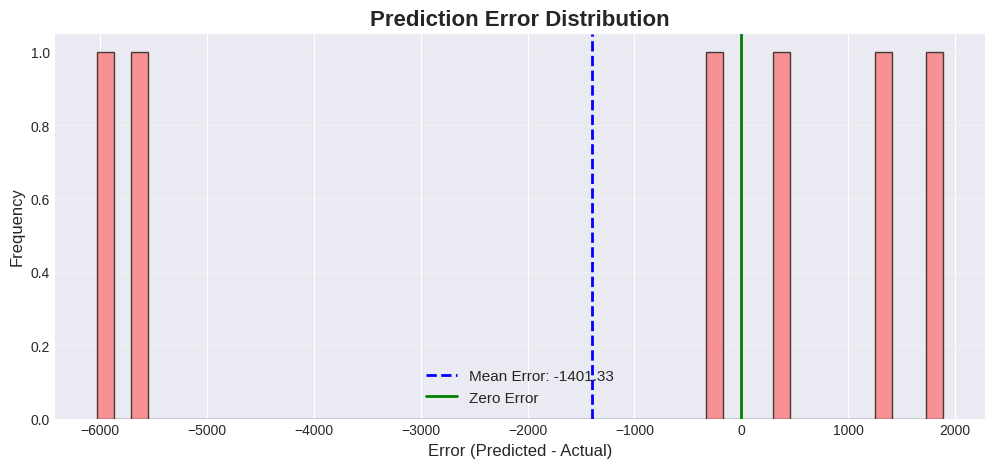

In [28]:
# Make predictions on test set
print("=" * 80)
print("MODEL EVALUATION".center(80))
print("=" * 80)

predictions = model.predict(X_test, verbose=0)

# Inverse transform to get actual values
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
mae = mean_absolute_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100

# Additional metrics
r2_score = 1 - (np.sum((y_test_actual - predictions_actual)**2) /
                np.sum((y_test_actual - np.mean(y_test_actual))**2))

print("\n PERFORMANCE METRICS:")
print(f"   Mean Absolute Error (MAE): {mae:.2f} bottles")
print(f"   Root Mean Squared Error (RMSE): {rmse:.2f} bottles")
print(f"   Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"   R² Score: {r2_score:.4f}")

print(f"\n ACCURACY INSIGHTS:")
print(f"   Average actual demand: {y_test_actual.mean():.0f} bottles/day")
print(f"   Average predicted demand: {predictions_actual.mean():.0f} bottles/day")
print(f"   Prediction accuracy: {100 - mape:.2f}%")

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Full test set comparison
axes[0].plot(y_test_actual, label='Actual Demand', linewidth=2,
            alpha=0.8, color='steelblue')
axes[0].plot(predictions_actual, label='Predicted Demand', linewidth=2,
            alpha=0.8, color='coral')
axes[0].set_title("Actual vs Predicted Demand (Full Test Set)",
                 fontsize=16, fontweight='bold')
axes[0].set_xlabel("Days", fontsize=12)
axes[0].set_ylabel("Quantity (Bottles)", fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Last N days - detailed view
num_test_samples = len(y_test_actual)
last_n_actual = y_test_actual[-num_test_samples:]
last_n_pred = predictions_actual[-num_test_samples:]

axes[1].plot(range(num_test_samples), last_n_actual.flatten(), marker='o', label='Actual',
            linewidth=2, markersize=6, color='steelblue')
axes[1].plot(range(num_test_samples), last_n_pred.flatten(), marker='s', label='Predicted',
            linewidth=2, markersize=6, color='coral')
axes[1].set_title(f"Last {num_test_samples} Days - Detailed Comparison",
                 fontsize=16, fontweight='bold')
axes[1].set_xlabel("Days", fontsize=12)
axes[1].set_ylabel("Quantity (Bottles)", fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

# Scatter plot - Predicted vs Actual
axes[2].scatter(y_test_actual, predictions_actual, alpha=0.6, s=50, color='#4ecdc4')
# Perfect prediction line
max_val = max(y_test_actual.max(), predictions_actual.max())
min_val = min(y_test_actual.min(), predictions_actual.min())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_title("Predicted vs Actual - Scatter Plot", fontsize=16, fontweight='bold')
axes[2].set_xlabel("Actual Demand", fontsize=12)
axes[2].set_ylabel("Predicted Demand", fontsize=12)
axes[2].legend(fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error analysis
errors = predictions_actual - y_test_actual
print("\n ERROR ANALYSIS:")
print(f"   Mean Error: {errors.mean():.2f} bottles")
print(f"   Error Std Dev: {errors.std():.2f} bottles")
print(f"   Max Overestimation: {errors.max():.2f} bottles")
print(f"   Max Underestimation: {errors.min():.2f} bottles")

# Error distribution
plt.figure(figsize=(12, 5))
plt.hist(errors, bins=50, edgecolor='black', color='#ff6b6b', alpha=0.7)
plt.axvline(errors.mean(), color='blue', linestyle='--', linewidth=2,
           label=f'Mean Error: {errors.mean():.2f}')
plt.axvline(0, color='green', linestyle='-', linewidth=2, label='Zero Error')
plt.title("Prediction Error Distribution", fontsize=16, fontweight='bold')
plt.xlabel("Error (Predicted - Actual)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.show()

                           FUTURE DEMAND FORECASTING                            



 NEXT 7 DAYS FORECAST:
----------------------------------------
   Day 1: 7,198 bottles
   Day 2: 7,180 bottles
   Day 3: 7,162 bottles
   Day 4: 7,139 bottles
   Day 5: 7,116 bottles
   Day 6: 7,094 bottles
   Day 7: 7,075 bottles

 FORECAST SUMMARY:
------------------------------------------------------------
   7-Day Forecast:
      Total: 49,964 bottles
      Average: 7,138 bottles/day
      Peak: 7,198 bottles
      Low: 7,075 bottles

   14-Day Forecast:
      Total: 99,216 bottles
      Average: 7,087 bottles/day

   30-Day Forecast:
      Total: 211,511 bottles
      Average: 7,050 bottles/day
      Expected range: 7,016 - 7,198 bottles/day


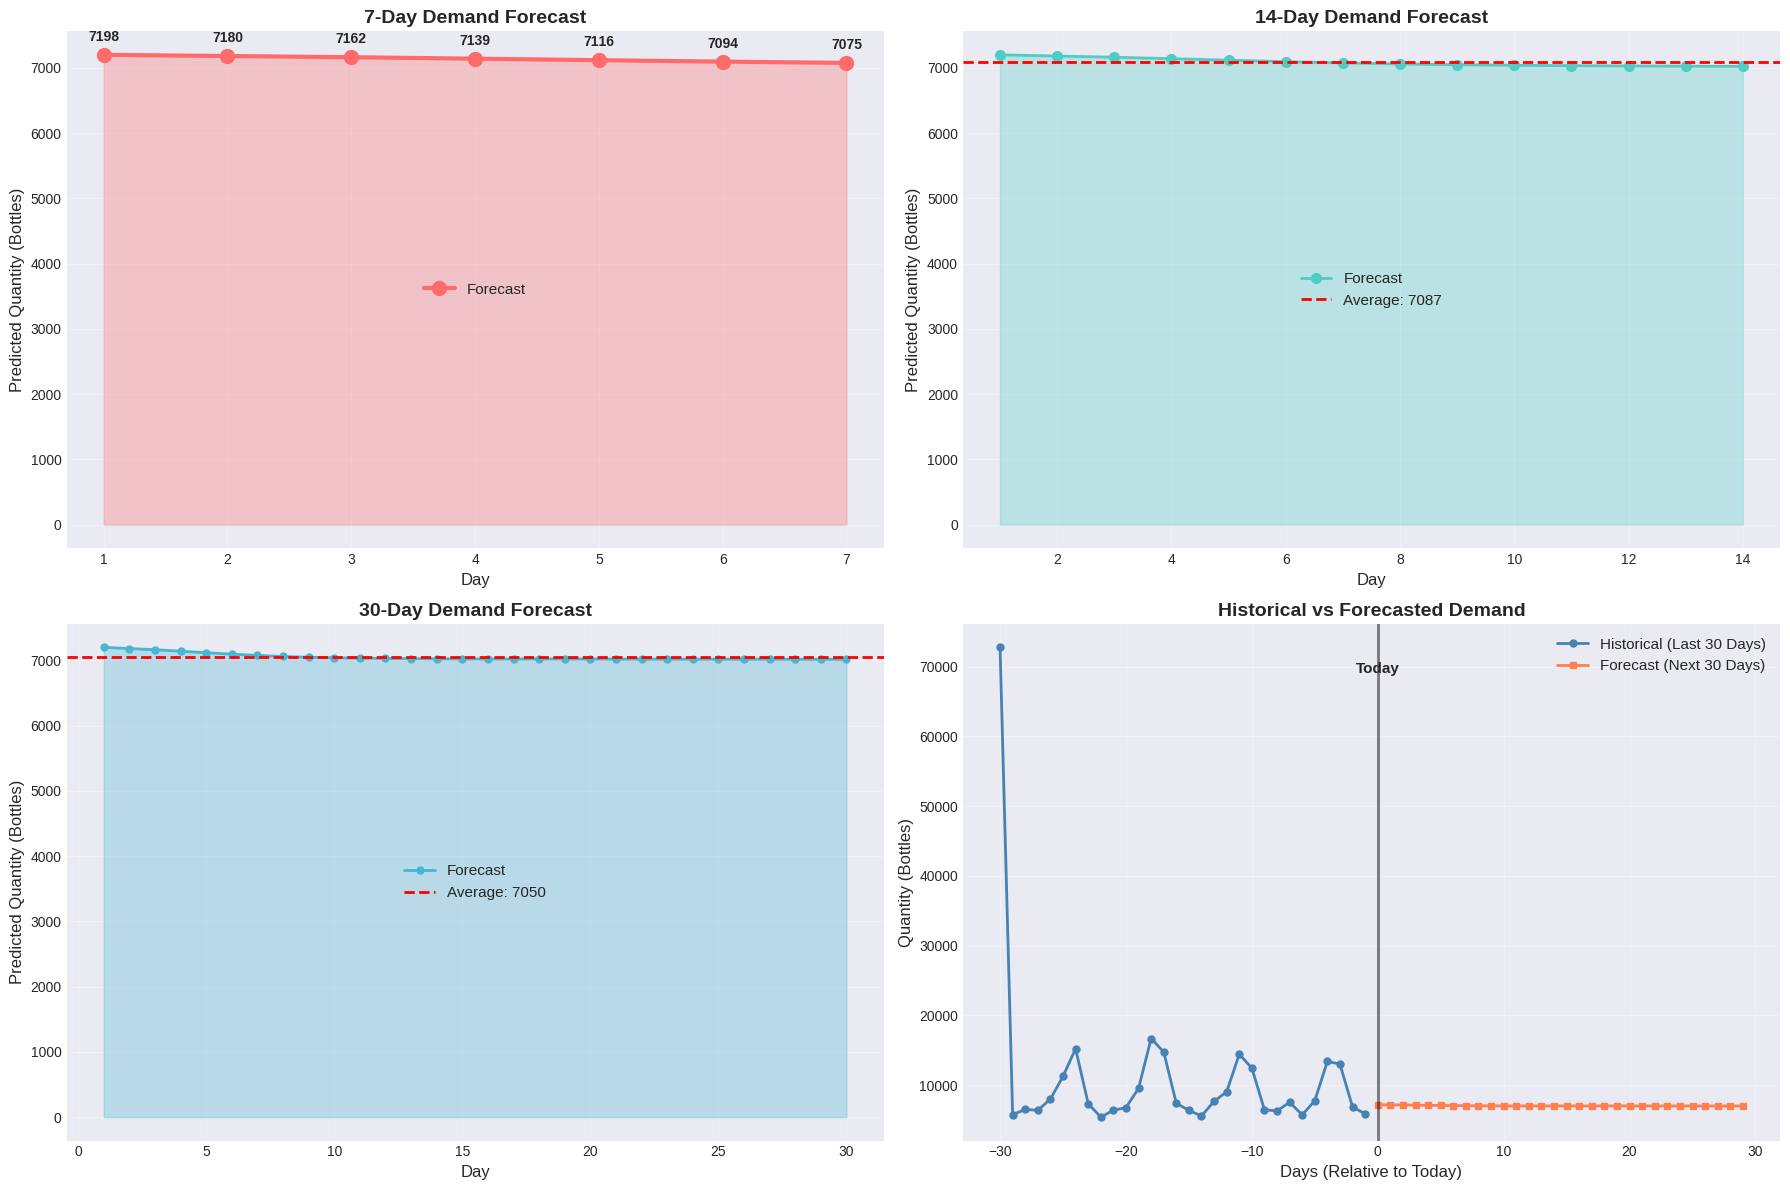


 WEEKLY BREAKDOWN (Next 4 Weeks):
------------------------------------------------------------
   Week 1: 49,964 bottles (avg 7,138/day)
   Week 2: 49,251 bottles (avg 7,036/day)
   Week 3: 49,141 bottles (avg 7,020/day)
   Week 4: 49,123 bottles (avg 7,018/day)

 30-day forecast saved to 'demand_forecast_30days.csv'


In [29]:
# Forecast future demand
print("=" * 80)
print("FUTURE DEMAND FORECASTING".center(80))
print("=" * 80)

def forecast_future(model, last_sequence, days=7, scaler=scaler):
    """
    Forecast future demand for specified number of days
    """
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(days):
        # Reshape for prediction
        pred_input = current_seq.reshape(1, lookback, 1)

        # Make prediction
        pred = model.predict(pred_input, verbose=0)
        predictions.append(pred[0, 0])

        # Update sequence (shift left and add new prediction)
        current_seq = np.append(current_seq[1:], pred[0, 0])

    # Inverse transform to get actual values
    predictions_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_actual

# Get last 60 days from scaled data
last_60_days = scaled_data[-lookback:].flatten()

# Forecast different periods
forecast_7 = forecast_future(model, last_60_days, days=7)
forecast_14 = forecast_future(model, last_60_days, days=14)
forecast_30 = forecast_future(model, last_60_days, days=30)

# Display forecasts
print("\n NEXT 7 DAYS FORECAST:")
print("-" * 40)
for i, val in enumerate(forecast_7, 1):
    print(f"   Day {i}: {val[0]:,.0f} bottles")

print(f"\n FORECAST SUMMARY:")
print("-" * 60)
print(f"   7-Day Forecast:")
print(f"      Total: {forecast_7.sum():,.0f} bottles")
print(f"      Average: {forecast_7.mean():,.0f} bottles/day")
print(f"      Peak: {forecast_7.max():,.0f} bottles")
print(f"      Low: {forecast_7.min():,.0f} bottles")

print(f"\n   14-Day Forecast:")
print(f"      Total: {forecast_14.sum():,.0f} bottles")
print(f"      Average: {forecast_14.mean():,.0f} bottles/day")

print(f"\n   30-Day Forecast:")
print(f"      Total: {forecast_30.sum():,.0f} bottles")
print(f"      Average: {forecast_30.mean():,.0f} bottles/day")
print(f"      Expected range: {forecast_30.min():,.0f} - {forecast_30.max():,.0f} bottles/day")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 7-day forecast
axes[0, 0].plot(range(1, 8), forecast_7, marker='o', linewidth=3,
               markersize=10, color='#ff6b6b', label='Forecast')
axes[0, 0].fill_between(range(1, 8), forecast_7.flatten(), alpha=0.3, color='#ff6b6b')
axes[0, 0].set_title("7-Day Demand Forecast", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Day", fontsize=12)
axes[0, 0].set_ylabel("Predicted Quantity (Bottles)", fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=11)

# Add value labels
for i, val in enumerate(forecast_7, 1):
    axes[0, 0].text(i, val[0] + forecast_7.max()*0.03, f'{val[0]:.0f}',
                   ha='center', fontsize=10, fontweight='bold')

# 14-day forecast
axes[0, 1].plot(range(1, 15), forecast_14, marker='o', linewidth=2,
               markersize=7, color='#4ecdc4', label='Forecast')
axes[0, 1].fill_between(range(1, 15), forecast_14.flatten(), alpha=0.3, color='#4ecdc4')
axes[0, 1].axhline(forecast_14.mean(), color='red', linestyle='--',
                  linewidth=2, label=f'Average: {forecast_14.mean():.0f}')
axes[0, 1].set_title("14-Day Demand Forecast", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Day", fontsize=12)
axes[0, 1].set_ylabel("Predicted Quantity (Bottles)", fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=11)

# 30-day forecast
axes[1, 0].plot(range(1, 31), forecast_30, marker='o', linewidth=2,
               markersize=5, color='#45b7d1', label='Forecast')
axes[1, 0].fill_between(range(1, 31), forecast_30.flatten(), alpha=0.3, color='#45b7d1')
axes[1, 0].axhline(forecast_30.mean(), color='red', linestyle='--',
                  linewidth=2, label=f'Average: {forecast_30.mean():.0f}')
axes[1, 0].set_title("30-Day Demand Forecast", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Day", fontsize=12)
axes[1, 0].set_ylabel("Predicted Quantity (Bottles)", fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=11)

# Historical + Forecast combined view
historical_last_30 = daily_sales_ts['quantity'].tail(30).values
historical_dates = range(-30, 0)
forecast_dates = range(0, 30)

axes[1, 1].plot(historical_dates, historical_last_30, marker='o', linewidth=2,
               markersize=5, color='steelblue', label='Historical (Last 30 Days)')
axes[1, 1].plot(forecast_dates, forecast_30, marker='s', linewidth=2,
               markersize=5, color='coral', label='Forecast (Next 30 Days)')
axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5)
axes[1, 1].text(0, max(historical_last_30.max(), forecast_30.max())*0.95,
               'Today', ha='center', fontsize=11, fontweight='bold')
axes[1, 1].set_title("Historical vs Forecasted Demand", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Days (Relative to Today)", fontsize=12)
axes[1, 1].set_ylabel("Quantity (Bottles)", fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Weekly forecast breakdown
print("\n WEEKLY BREAKDOWN (Next 4 Weeks):")
print("-" * 60)
for week in range(4):
    start_day = week * 7
    end_day = min(start_day + 7, 30)
    week_forecast = forecast_30[start_day:end_day]
    print(f"   Week {week+1}: {week_forecast.sum():,.0f} bottles " +
          f"(avg {week_forecast.mean():,.0f}/day)")

# Save forecast results
forecast_df = pd.DataFrame({
    'day': range(1, 31),
    'forecasted_demand': forecast_30.flatten()
})
forecast_df.to_csv('demand_forecast_30days.csv', index=False)
print("\n 30-day forecast saved to 'demand_forecast_30days.csv'")

In [30]:
# Generate business recommendations
print("\n" + "=" * 80)
print("BUSINESS RECOMMENDATIONS & ACTION ITEMS".center(80))
print("=" * 80)

# Calculate inventory requirements based on forecast
forecast_7_total = forecast_7.sum()
forecast_30_total = forecast_30.sum()

print("\n INVENTORY PLANNING:")
print("-" * 60)
print(f"   Next Week Requirements: {forecast_7_total:,.0f} bottles")
print(f"   Next Month Requirements: {forecast_30_total:,.0f} bottles")
print(f"   Recommended Safety Stock: {forecast_30_total * 0.15:,.0f} bottles (15%)")
print(f"   Total Inventory Target: {forecast_30_total * 1.15:,.0f} bottles")

print("\n CATEGORY-BASED RECOMMENDATIONS:")
print("-" * 60)

for category in ['A', 'B', 'C']:
    cat_metrics = inventory_metrics[inventory_metrics['abc_category']==category]
    total_eoq = cat_metrics['eoq'].sum()
    avg_rop = cat_metrics['rop'].mean()
    num_products = len(cat_metrics)

    print(f"\n   Category {category}:")
    print(f"      Number of products: {num_products}")
    print(f"      Total EOQ: {total_eoq:,.0f} bottles")
    print(f"      Average ROP: {avg_rop:,.0f} bottles")
    print(f"      Ordering priority: {'HIGH' if category == 'A' else 'MEDIUM' if category == 'B' else 'LOW'}")

print("\n KEY RECOMMENDATIONS:")
print("-" * 60)
print("   1. Focus on Category A products - they drive 80% of revenue")
print("   2. Maintain higher safety stock for fast-moving items")
print("   3. Review slow-moving Category C products quarterly")
print(f"   4. Average lead time is {purchases_df['lead_time_days'].mean():.0f} days - plan accordingly" if 'lead_time_days' in purchases_df.columns else "   4. Establish vendor lead time tracking")
print("   5. Use demand forecasts for weekly purchase order planning")
print("   6. Set up automated reorder alerts at ROP thresholds")

print("\n POTENTIAL STOCKOUT RISKS:")
print("-" * 60)

# Identify products that might need attention
high_demand_products = inventory_metrics.nlargest(10, 'daily_demand')
print("\n   Top 10 High-Velocity Products Needing Close Monitoring:")
for idx, row in high_demand_products.iterrows():
    print(f"      • {row['product']}: {row['daily_demand']:.0f} bottles/day " +
          f"(ROP: {row['rop']:.0f}, Safety Stock: {row['safety_stock']:.0f})")

print("\n" + "=" * 80)


                    BUSINESS RECOMMENDATIONS & ACTION ITEMS                     

 INVENTORY PLANNING:
------------------------------------------------------------
   Next Week Requirements: 49,964 bottles
   Next Month Requirements: 211,511 bottles
   Recommended Safety Stock: 31,727 bottles (15%)
   Total Inventory Target: 243,238 bottles

 CATEGORY-BASED RECOMMENDATIONS:
------------------------------------------------------------

   Category A:
      Number of products: 1502
      Total EOQ: 515,813 bottles
      Average ROP: 27 bottles
      Ordering priority: HIGH

   Category B:
      Number of products: 1813
      Total EOQ: 293,846 bottles
      Average ROP: 8 bottles
      Ordering priority: MEDIUM

   Category C:
      Number of products: 4343
      Total EOQ: 159,992 bottles
      Average ROP: 1 bottles
      Ordering priority: LOW

 KEY RECOMMENDATIONS:
------------------------------------------------------------
   1. Focus on Category A products - they drive 80% of rev